<a href="https://colab.research.google.com/github/AaronM44/DAOTW-Assignment-1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAOTW - Assignment 1

## Introduction

We have been asked to investigate the relationship between weather and the number of traffic collisions on any given day. We will then be required to create both linear regression and deep neural network models that can be used to accurately predict the number of collisions on a particular day.

In this first part we will gather the data and perform some initial analysis before creating the datasets which will be used for our models.

## Packages

### Install Packages

In [115]:
install.packages("patchwork")
install.packages("ggfortify")
install.packages("tidymodels")
install.packages("corrplot")
install.packages("RColorBrewer")
install.packages("lubridate")
install.packages('weathermetrics')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Import Packages

In [116]:
library(tidyverse)
library(broom)
library(patchwork)
library(scales)
library(ggfortify)
library(tidymodels)
library(corrplot)
library(RColorBrewer)
library(lubridate)
library(weathermetrics)

## Import Data

In [117]:
weather <- read.csv("https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/data/weather.csv")

In [118]:
collated <- read.csv("https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/data/collated_collision_data.csv")

In [119]:
contributing_factors <- read.csv("https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/data/contributing_factors.csv")

### SQL Used To Create Datasets

#### Weather

#### Collated Collisions

#### Contributing Factors

## Dataset Info

### Collisions

[Information on these descriptions was found on the noaa site](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt)


*   DEWP - Mean dew point for the day in degrees Fahrenheit to tenths. Missing = 9999.9
*   SLP - Mean sea level pressure for the day in millibars to tenths. Missing = 9999.9
* VISIB - Mean visibility for the day in miles to tenths. Missing = 999.9
* WDSP - Mean wind speed for the day in knots to tenths.  Missing = 999.9
* MXSPD (MXPSD in the dataset) - Maximum sustained wind speed reported for the day in knots to tenths. Missing = 999.9
* GUST - Maximum wind gust reported for the day in knots to tenths.  Missing = 999.9
* MAX - Maximum temperature reported during the day in Fahrenheit to tenths. Missing = 9999.9
* PRCP - Total precipitation (rain and/or melted snow) reported during the day in inches
 and hundredths; will usually not end with the midnight observation (i.e. may include
latter part of previous day). “0” indicates no measurable precipitation (includes a trace).   
Missing = 99.99
* SNDP - Snow depth in inches to tenths. It is the last report for the day if reported more than once. Missing = 999.9



## Dataset Transformations

### Contributing Factors

### Collisions

In the Dataset Info section we saw that missing data has been coded as numerical values. These will negatively affect our analysis and if left in the dataset, the subsequent models as well.

The first thing we'll do is replace these values with NA so we can get a better idea of how prominent they are.

In [120]:
# Missing values coded as 9999.9
collated_clean <- collated %>%
  mutate(across(c(dewp, slp, max, min), na_if, 9999.9))

# Missing values coded as 999.9
collated_clean <- collated_clean %>%
  mutate(across(c(visib, wdsp, mxpsd, gust, sndp), na_if, 999.9))

# Missing values coded as 99.99
collated_clean <- collated_clean %>%
  mutate(prcp = na_if(prcp, 99.99))

Temperatures in the dataset are in fahrenheit and wind speeds are in knots. I feel more comfortable working with celsius and mph however, so I'm going to convert these. This won't make any difference to our analysis or models, it's purely preference.

In [121]:
# Temperatures
collated_clean <- collated_clean %>%
  mutate(across(c(temp, dewp, min, max), .fns = fahrenheit.to.celsius, 1))

# Wind Speed
collated_clean <- collated_clean %>%
  mutate(across(c(wdsp, mxpsd, gust), .fns = knots_to_speed, "mph", 1))


Warning message in fn(col, ...):
“Some of the observations in the data gave negative wind speeds. Since wind speed cannot have a negative value, these observations were set to 'NA'.”
Warning message in fn(col, ...):
“Some of the observations in the data gave negative wind speeds. Since wind speed cannot have a negative value, these observations were set to 'NA'.”


This gave a warning message that some values were converted due to having a negative windspeed but this was the function trying to convert values that were already NA. I checked the number of NAs before and after using the function.

## Dataset Summaries

### Collisions

In [122]:
head(collated_clean)

,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,num_collisions
,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,2,2018,1,2,2018-01-02,-9.6,-16.7,1024.9,10.0,14.8,23.0,35.8,-7.8,-15.0,0.00,NA,0,654
2,1,2018,1,1,2018-01-01,-12.5,-18.1,1022.2,10.0,17.3,20.8,28.9,-6.1,-15.0,0.00,NA,0,453
3,5,2014,1,24,2014-01-24,-9.6,-18.1,1022.4,10.0,13.6,18.3,26.4,-5.0,-12.8,0.00,NA,0,705
4,4,2015,1,8,2015-01-08,-10.5,-19.1,1022.7,9.9,17.0,24.2,34.4,-2.8,-14.4,0.00,NA,0,573
5,6,2018,1,6,2018-01-06,-10.4,-17.9,1013.5,10.0,25.8,32.2,44.9,-2.8,-11.7,0.00,NA,0,599
6,4,2014,1,30,2014-01-30,-5.6,-14.6,1027.2,10.0,9.3,18.3,27.7,-2.8,-10.6,0.01,NA,0,657


In [123]:
summary(collated_clean)

      day             year            mo               da       
 Min.   :1.000   Min.   :2012   Min.   : 1.000   Min.   : 1.00  
 1st Qu.:2.000   1st Qu.:2014   1st Qu.: 4.000   1st Qu.: 8.00  
 Median :4.000   Median :2016   Median : 7.000   Median :16.00  
 Mean   :3.999   Mean   :2016   Mean   : 6.699   Mean   :15.74  
 3rd Qu.:6.000   3rd Qu.:2018   3rd Qu.:10.000   3rd Qu.:23.00  
 Max.   :7.000   Max.   :2020   Max.   :12.000   Max.   :31.00  
                                                                
 collision_date          temp             dewp              slp      
 Length:3106        Min.   :-14.60   Min.   :-21.500   Min.   : 989  
 Class :character   1st Qu.:  5.10   1st Qu.:  0.300   1st Qu.:1012  
 Mode  :character   Median : 11.40   Median :  7.600   Median :1017  
                    Mean   : 11.25   Mean   :  7.041   Mean   :1017  
                    3rd Qu.: 18.20   3rd Qu.: 15.100   3rd Qu.:1022  
                    Max.   : 30.40   Max.   : 23.400   Max. 

Snow Depth (sndp) has only one true value and the rest are NAs. Around a third of the records have an NA value for Gust Speed (gust).

It can sometimes be useful to get a look at the rows containing the minimum and maximum values of our independant variable.

Highest

In [124]:
# Highest
collated_clean %>%
  slice_max(n = 1, num_collisions)

day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,num_collisions
<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
2,2014,1,21,2014-01-21,-1.6,-8.1,1012.1,8.5,14.5,25.3,33.3,8.3,-5,0,NA,1,1161




* January
* Tuesday
* Fairly low temperature
* Fog



Lowest

In [125]:
# Lowest
collated_clean %>%
  slice(which.min(num_collisions))

day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,num_collisions
<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
7,2020,4,5,2020-04-05,5.4,2.4,1017.5,10,6.9,10.2,NA,10,1.7,0.01,NA,0,94


#### Distribution

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


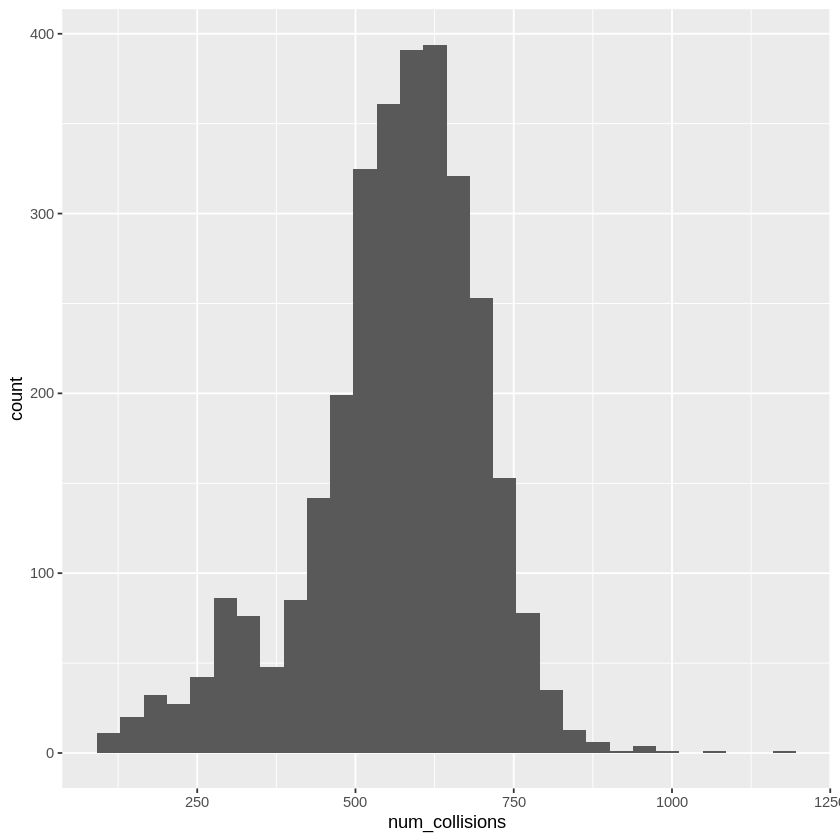

In [126]:
p_num_collisions <- ggplot(collated_clean, aes(x = num_collisions)) +
  geom_histogram()

p_num_collisions

Distribution of collision count is positively skewed.

In [127]:
missing.values <- collated_clean %>%
    gather(key = "key", value = "val") %>%
    mutate(is.missing = is.na(val)) %>%
    group_by(key, is.missing) %>%
    summarise(num.missing = n()) %>%
    filter(is.missing == T) %>%
    select(-is.missing) %>%
    arrange(desc(num.missing)) 



`summarise()` has grouped output by 'key'. You can override using the `.groups`
argument.


It's always useful when dealing with time series data to get a visual overview of the entire dataset in order to spot any patterns or abnormalities that could reduce the effectiveness of our analysis.

In [128]:
# Add day of year column
collated_clean <- collated_clean %>%
  mutate(dayofyear = yday(collision_date))

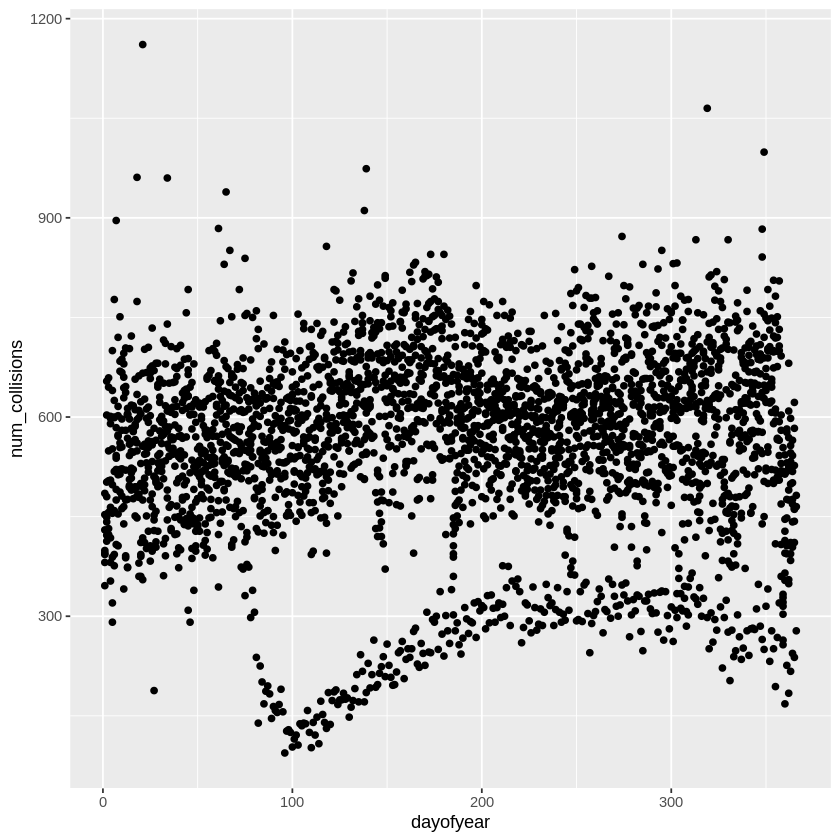

In [129]:
ggplot(collated_clean, aes(x = dayofyear, y = num_collisions)) +
  geom_point()

Looks like we have a seasonal trend where the number of collisions are generally higher in the early summer months (May-July), falling after that before rising again towards December.

There's also something strange going on at the bottom of the plot. Could be missing data but grouping by year might also give us something useful to go on.

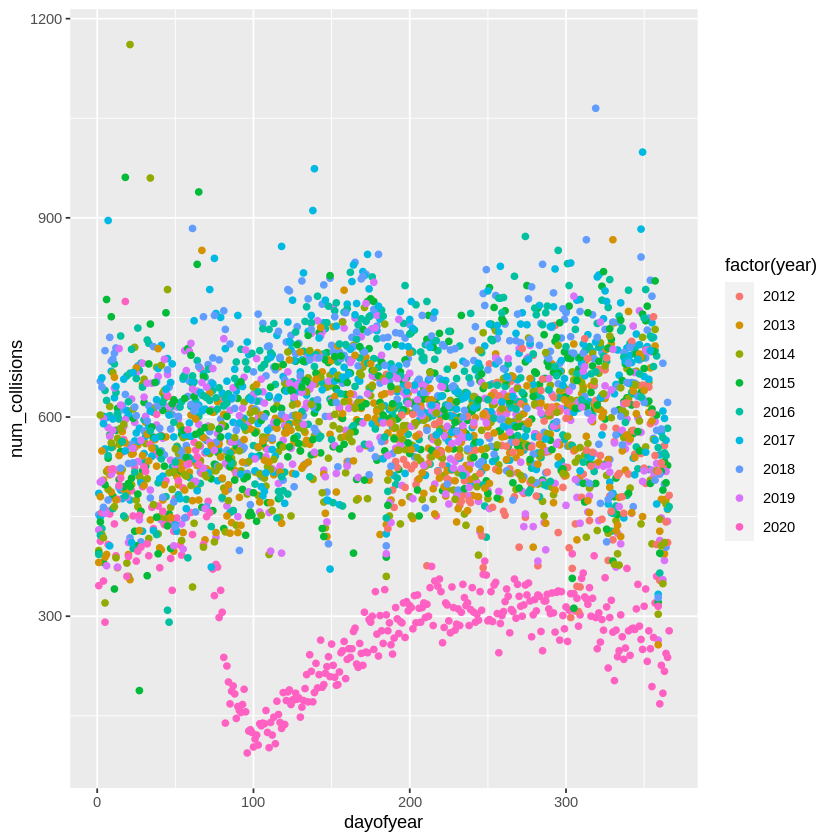

In [130]:
ggplot(collated_clean, aes(x = dayofyear, y = num_collisions, colour = factor(year))) +
  geom_point()

Definitely something going on with 2020 but it's difficult to really tell with this plot. 

Viewing the dataset over the whole timeline should work.

In [131]:
# Order by date (asc) then add an index column
collated_clean <- collated_clean %>%
  arrange(collision_date) %>%
  mutate(dayindex = row_number())

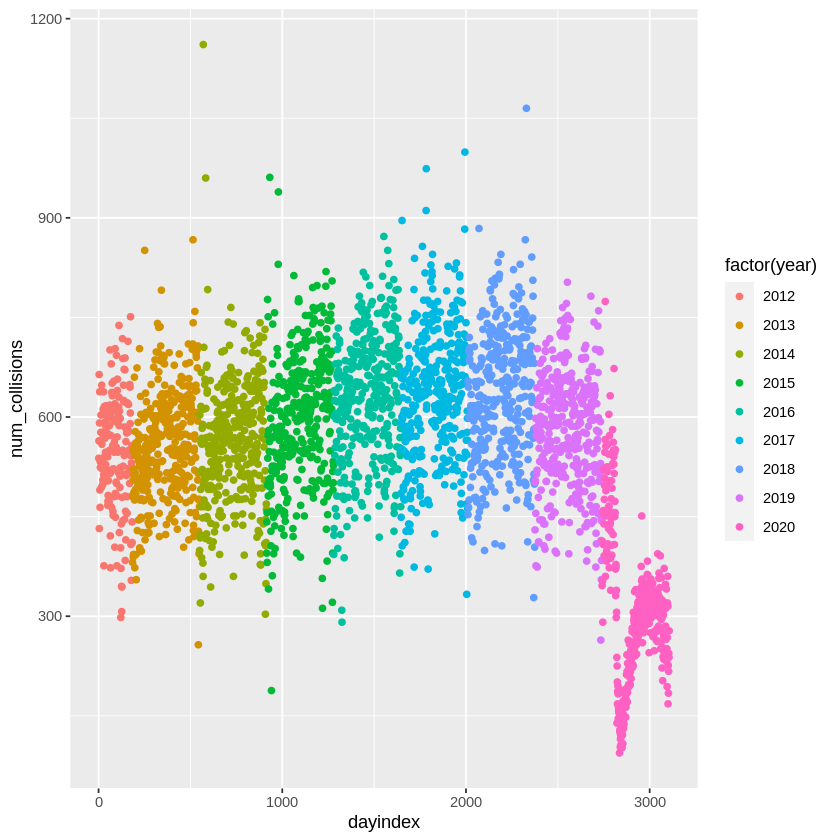

In [132]:
ggplot(collated_clean, aes(x = dayindex, y = num_collisions, colour = factor(year))) +
  geom_point()

Must admit that it took me a few minutes to remember that COVID happened but the sharp drop in collisions would coincide with the events in NYC around that time therefore I will remove this year from the dataset.

[COVID Timeline NYC](https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986)



In [133]:
# Remove 2020 from the dataset
collated_clean_rm_20 <- collated_clean %>%
  filter(year != 2020)

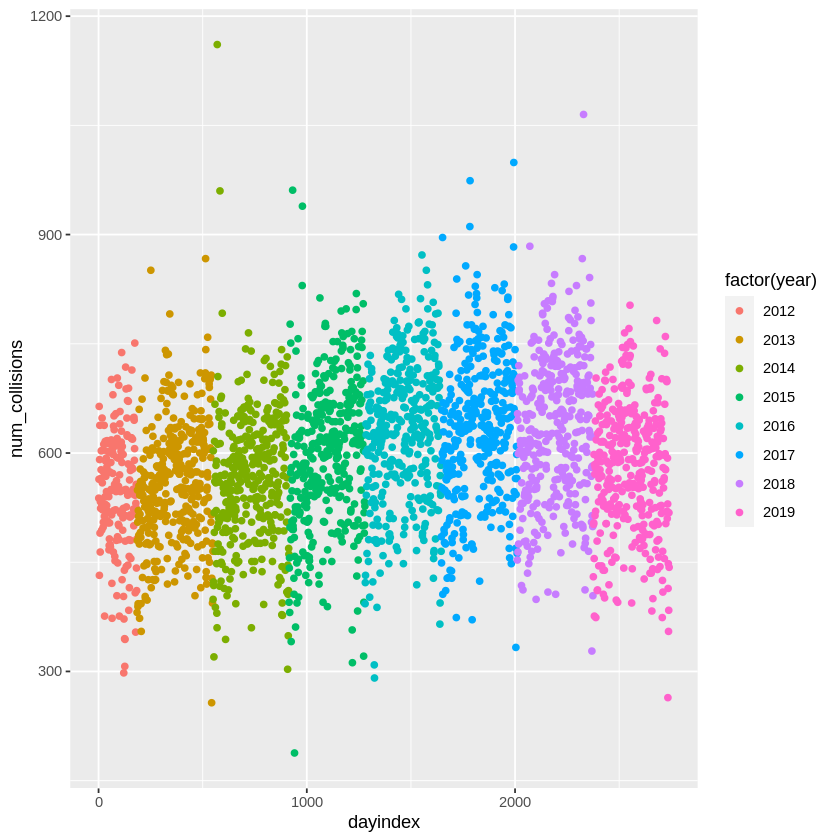

In [134]:
ggplot(collated_clean_rm_20, aes(x = dayindex, y = num_collisions, colour = factor(year))) +
  geom_point()

Looks better.

In general there was an upwards trend in the number of collisions per year that peaked in 2017 but then started to decline in 2018 and again in 2019.

## Correlations

I'd like to get a look at each of the variables in order to see what we're dealing with and if any of the variables have any issues that we might need to clean up.

### Temperature

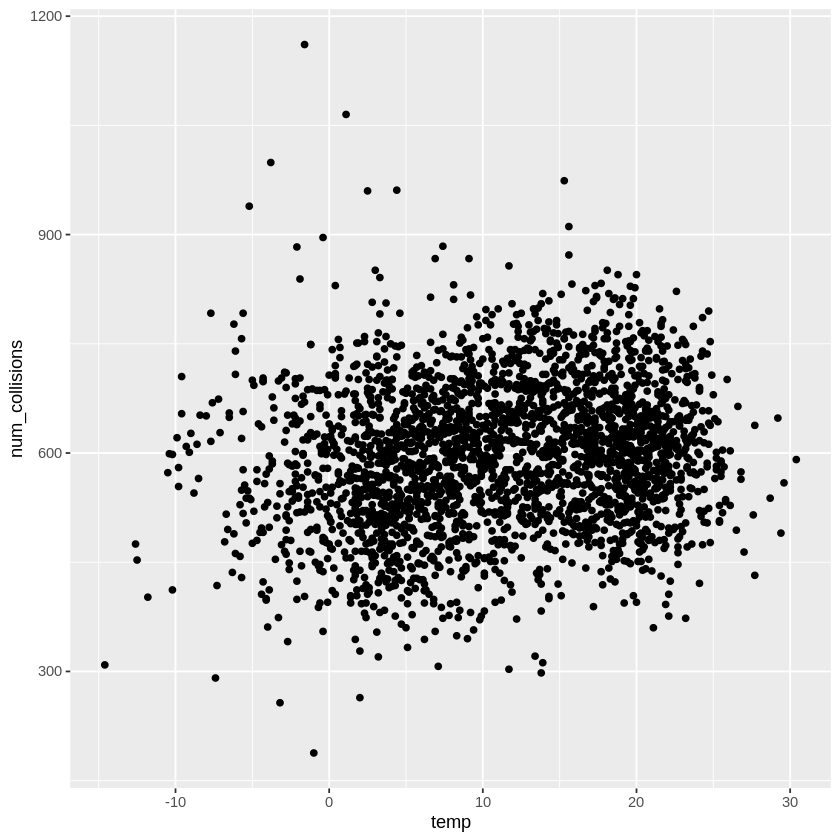

In [135]:
# Temperature vs Collisions
p_cor_temp_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = temp, y = num_collisions)) +
  geom_point()

p_cor_temp_collisions

In [136]:
cor(collated_clean_rm_20$temp, collated_clean_rm_20$num_collisions)

[1] 0.1708116

Not great.

### Dew Point

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


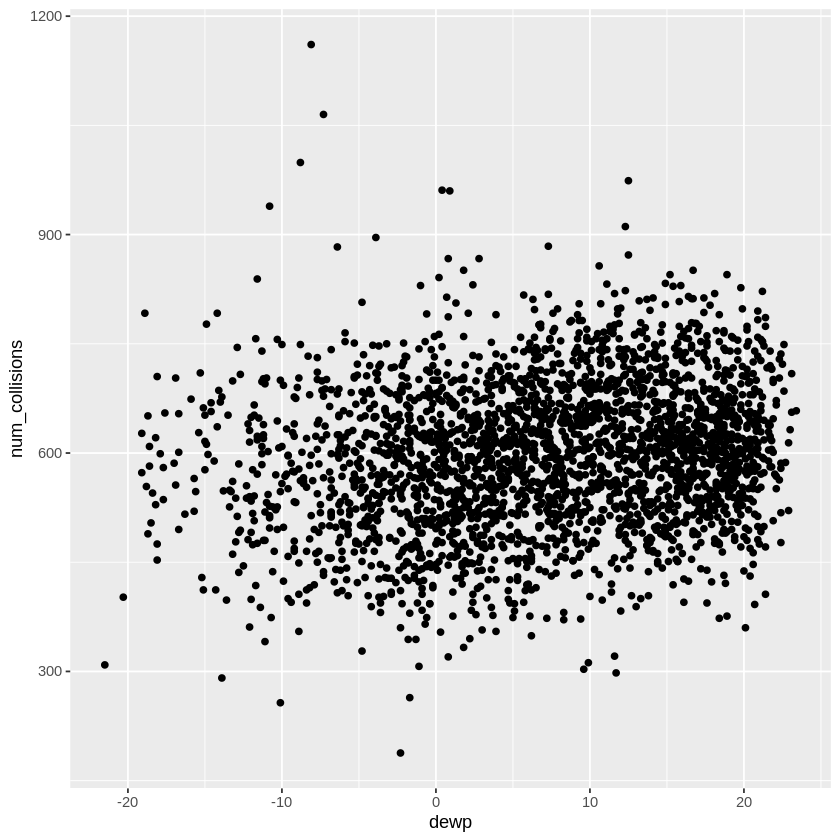

In [137]:
# Dew Point vs Collisions
p_cor_dewp_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = dewp, y = num_collisions)) +
  geom_point()

p_cor_dewp_collisions

In [138]:
# Need to remove NAs in order for the correlation function to work
cor(collated_clean_rm_20$dewp, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] 0.1790634

Again not a great correlation.

### Sea Level Pressure

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


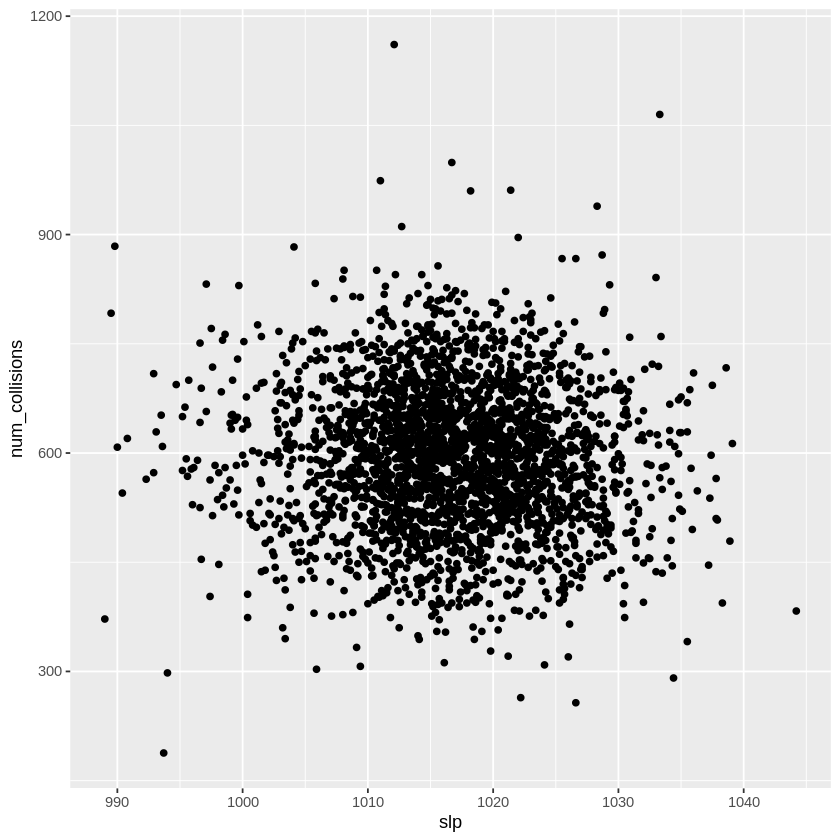

In [139]:
# Sea Level Pressure vs Collisions
p_cor_slp_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = slp, y = num_collisions)) +
  geom_point()

p_cor_slp_collisions

In [140]:
cor(collated_clean_rm_20$slp, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] -0.0458649

Worse than the others.

### Visibility

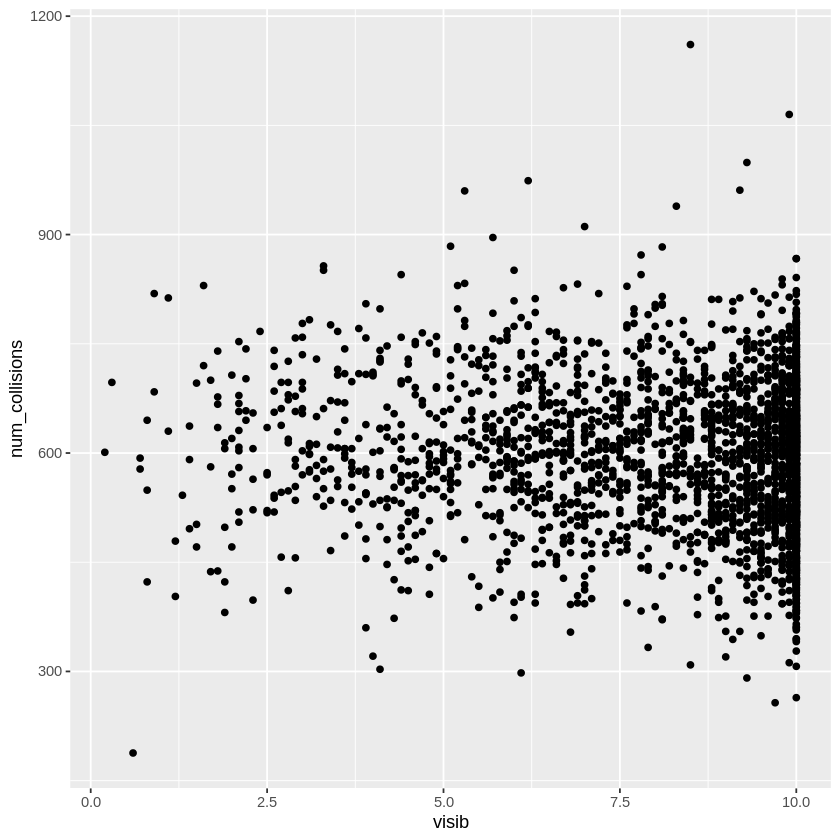

In [141]:
# Visibility vs Collisions
p_cor_visib_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = visib, y = num_collisions)) +
  geom_point()

p_cor_visib_collisions

In [142]:
cor(collated_clean_rm_20$visib, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] -0.07742423

Not good.

### Max Wind Speed

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


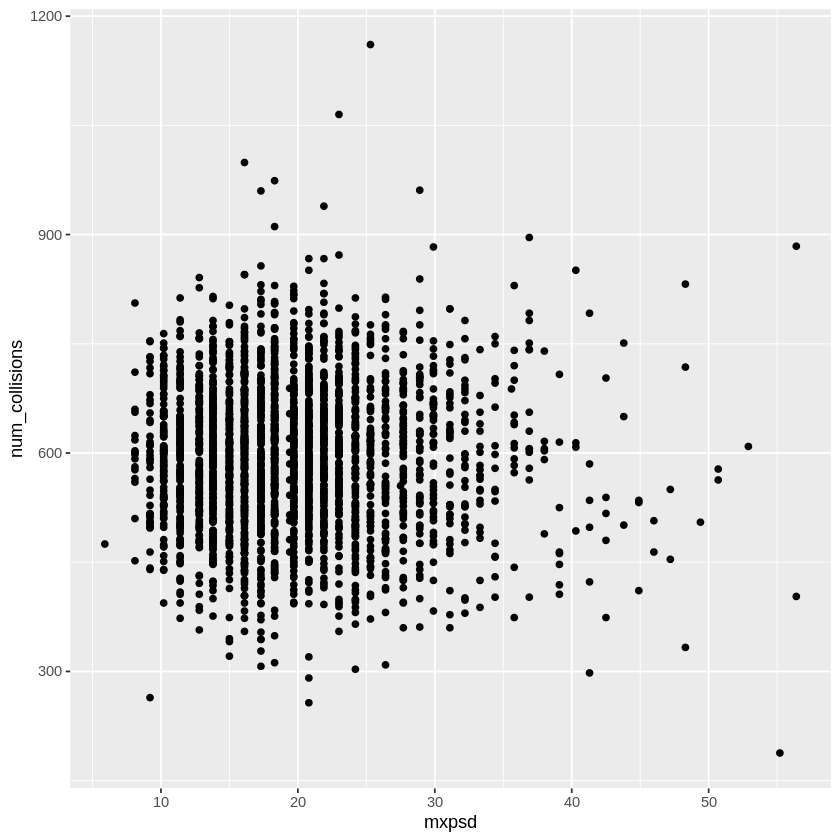

In [143]:
# Max Wind Speed vs Collisions
p_cor_mxpsd_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = mxpsd, y = num_collisions)) +
  geom_point()

p_cor_mxpsd_collisions

In [144]:
cor(collated_clean_rm_20$mxpsd, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] -0.02020917

### Average Wind Speed

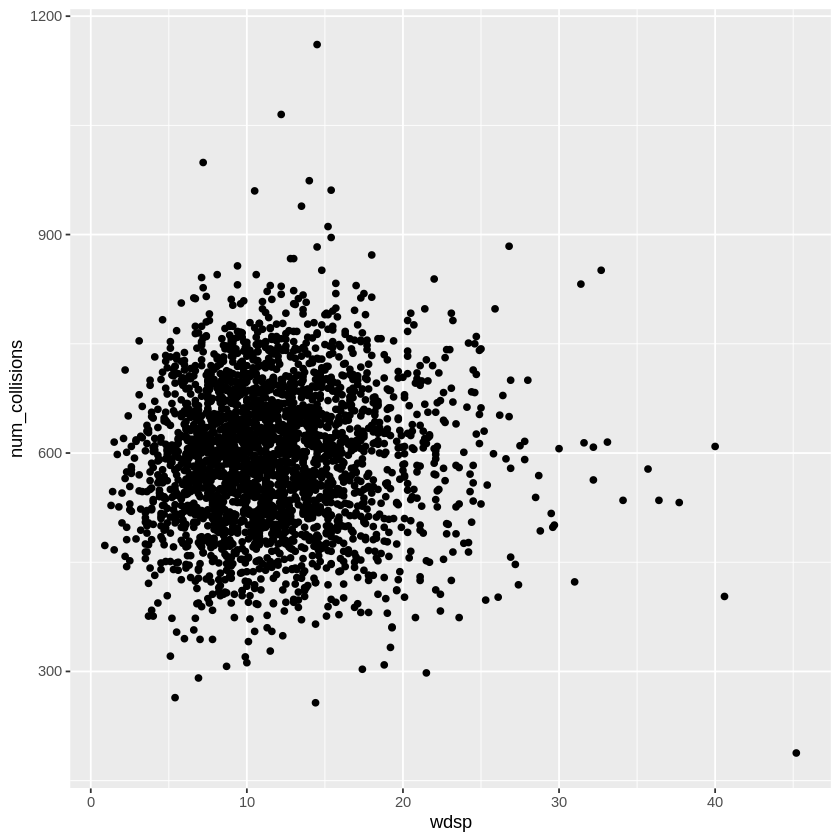

In [145]:
# Wind Speed vs Collisions
p_cor_wdsp_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = wdsp, y = num_collisions)) +
  geom_point()

p_cor_wdsp_collisions

In [146]:
cor(collated_clean_rm_20$wdsp, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] 0.02968317

### Gust Speed

Warning message:
“Removed 988 rows containing missing values (`geom_point()`).”


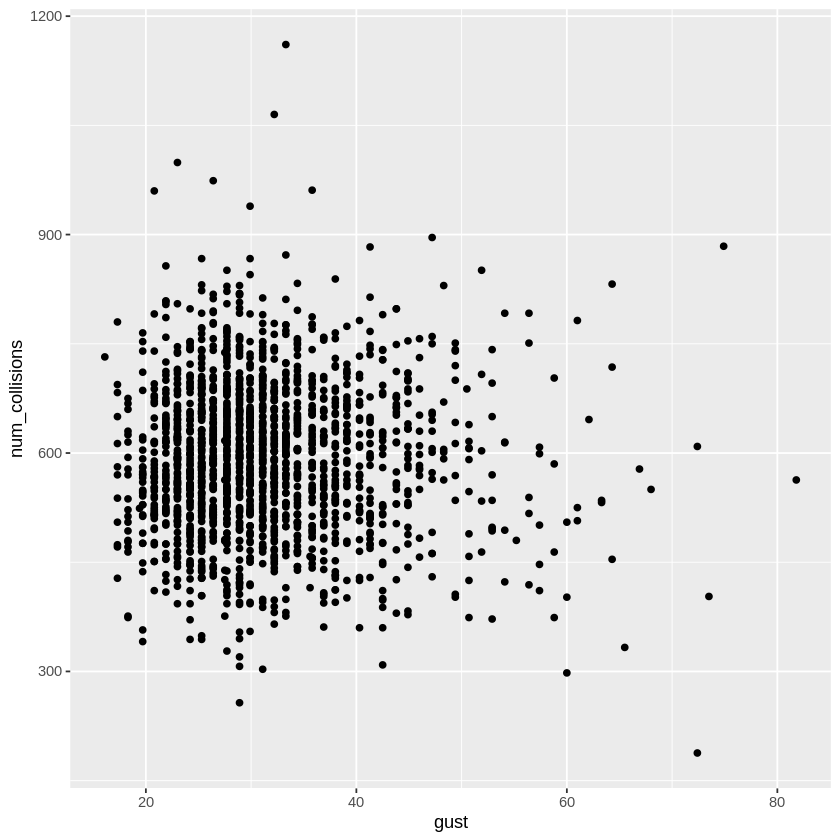

In [147]:
# Gust vs Collisions
p_cor_gust_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = gust, y = num_collisions)) +
  geom_point()

p_cor_gust_collisions

In [148]:
cor(collated_clean_rm_20$gust, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] -0.02438904

### Max Temperature

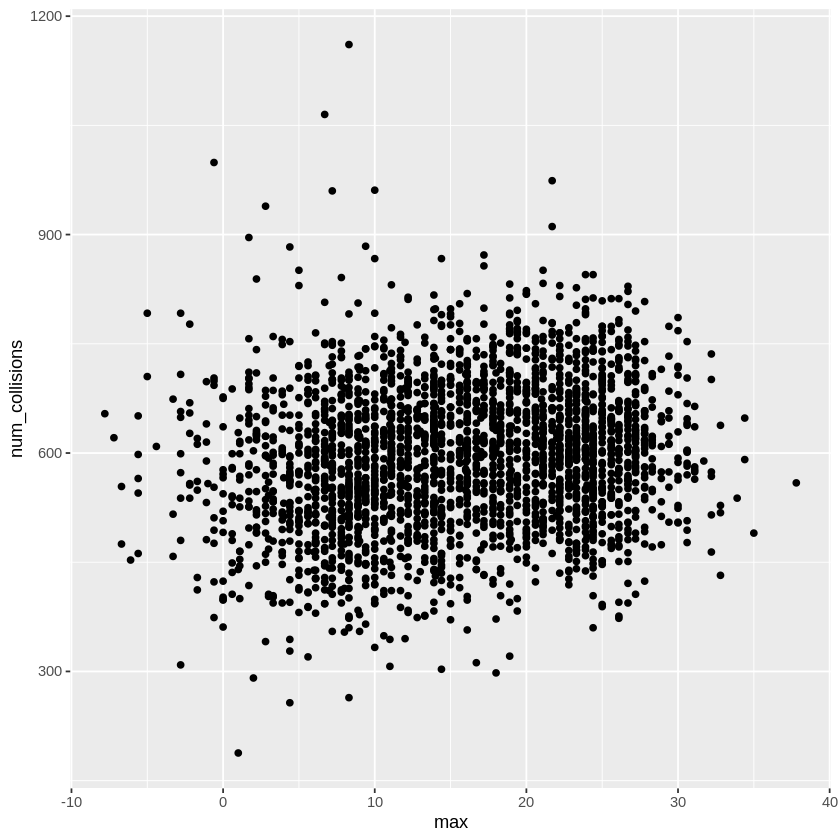

In [149]:
# Max Temp vs Collisions
p_cor_max_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = max, y = num_collisions)) +
  geom_point()

p_cor_max_collisions

In [150]:
cor(collated_clean_rm_20$max, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] 0.1735756

### Minimum Temperature

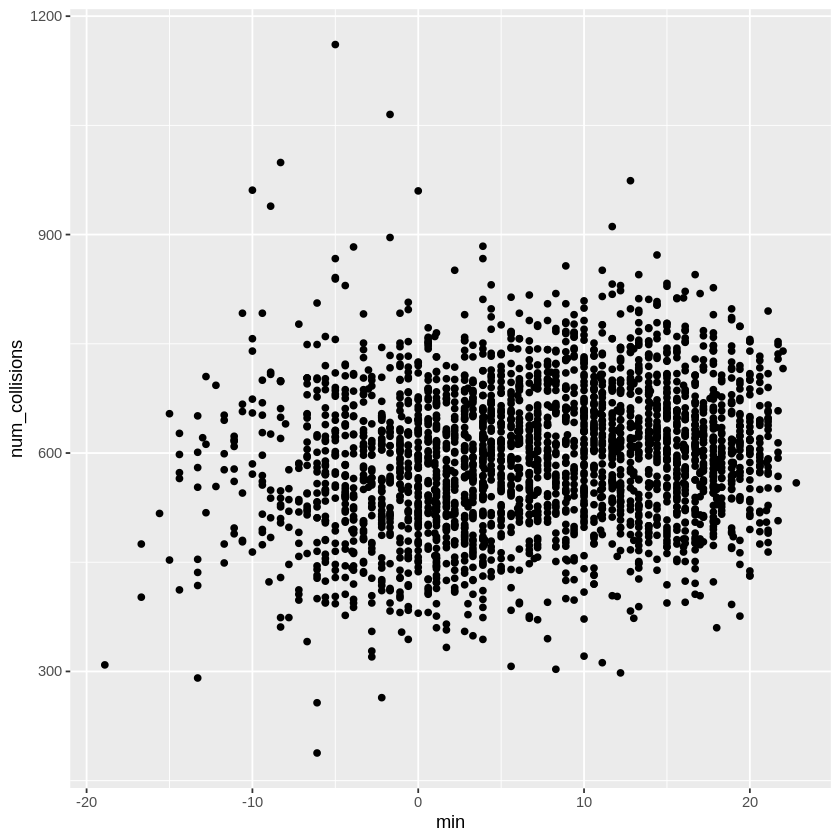

In [151]:
# Min Temp vs Collisions
p_cor_min_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = min, y = num_collisions)) +
  geom_point()

p_cor_min_collisions

In [152]:
cor(collated_clean_rm_20$min, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] 0.1693769

### Precipitation

Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”


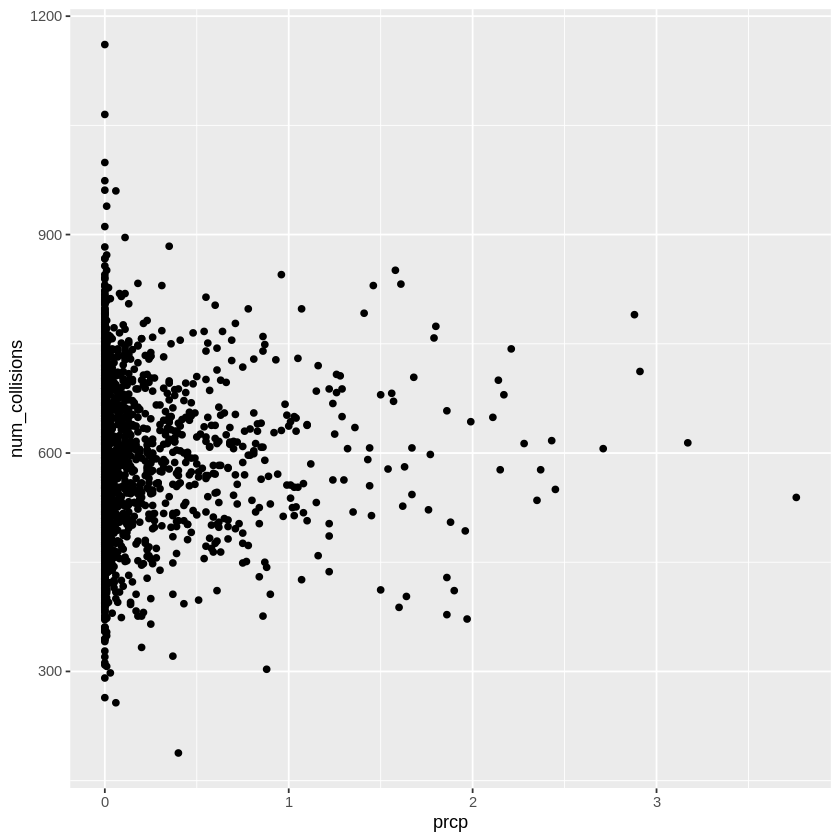

In [153]:
# Precipitation vs Collisions
p_cor_prcp_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = prcp, y = num_collisions)) +
  geom_point()

p_cor_prcp_collisions

In [154]:
cor(collated_clean_rm_20$prcp, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] 0.0009862742

Worst of the bunch so far

### Snow Depth

Warning message:
“Removed 2739 rows containing missing values (`geom_point()`).”


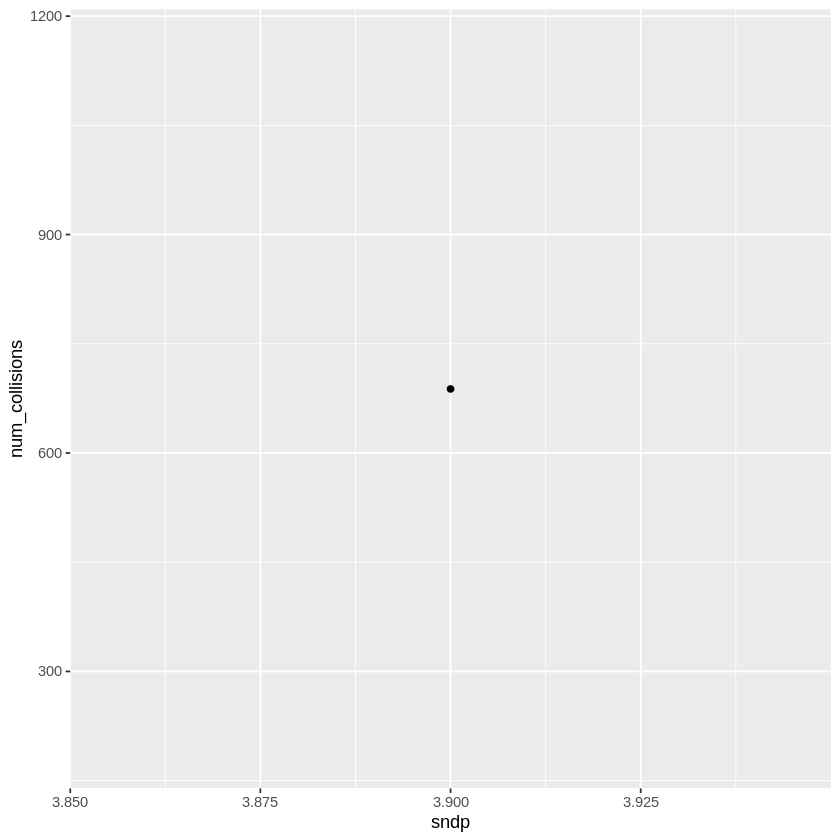

In [155]:
# Snow Depth vs Collisions
p_cor_sndp_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = sndp, y = num_collisions)) +
  geom_point()

p_cor_sndp_collisions

In [156]:
cor(collated_clean_rm_20$sndp, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] NA

Only one record so will most likely remove this variable.

### Fog

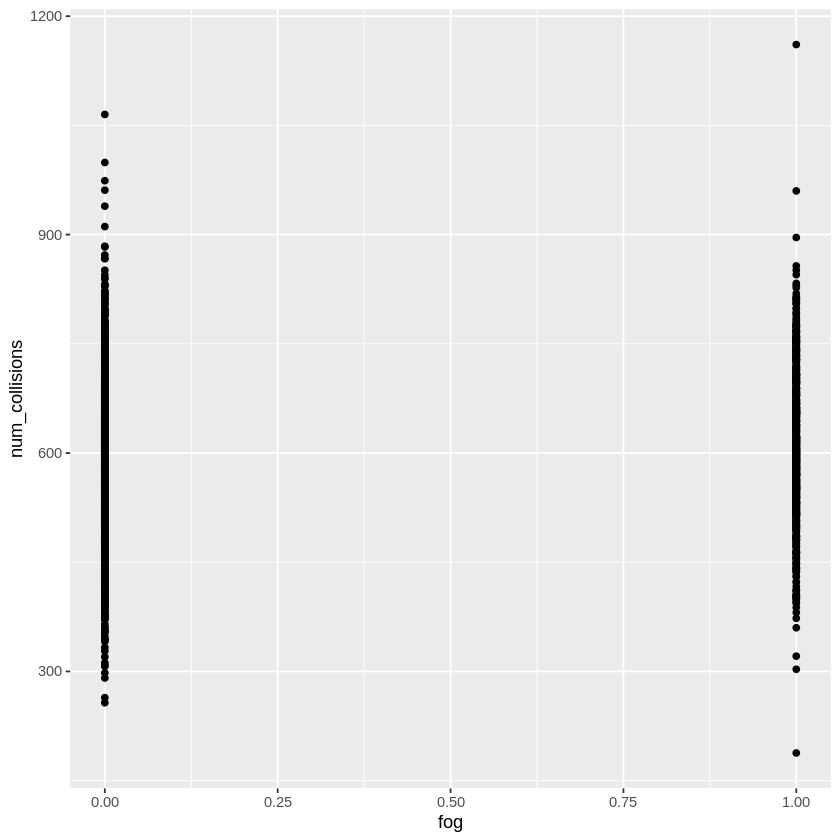

In [157]:
# Fog vs Collisions
p_cor_fog_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = fog, y = num_collisions)) +
  geom_point()

p_cor_fog_collisions

In [158]:
cor(collated_clean_rm_20$fog, collated_clean_rm_20$num_collisions, use = "complete.obs")

[1] 0.08377604

### Day of the Week

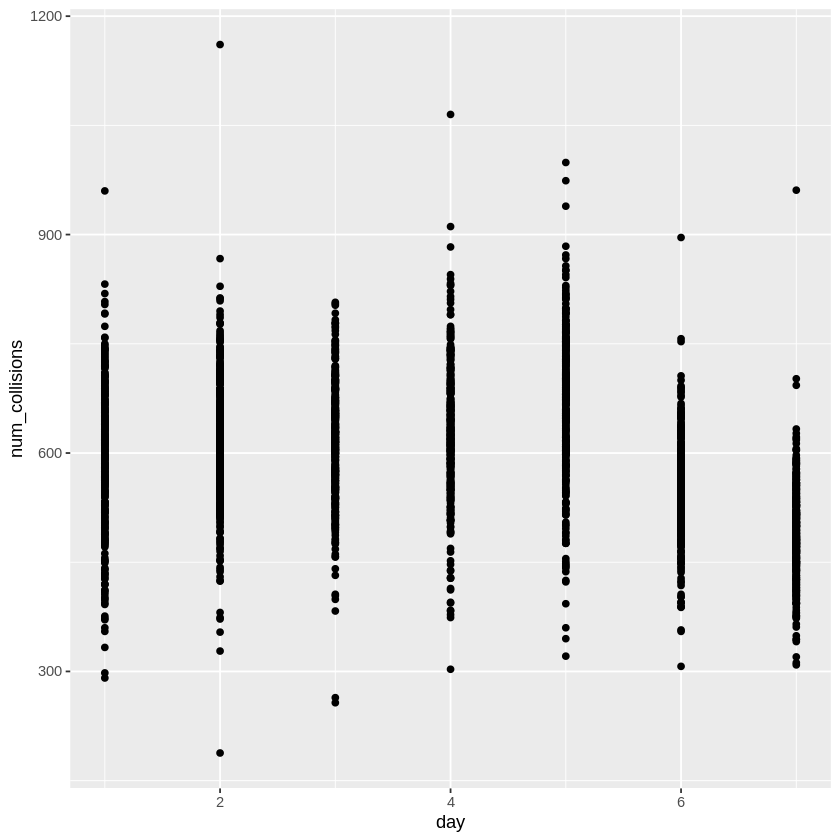

In [159]:
# Day vs Collisions
p_cor_day_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = day, y = num_collisions)) +
  geom_point()

p_cor_day_collisions

In [160]:
cor(collated_clean_rm_20$day, collated_clean_rm_20$num_collisions)

[1] -0.2858827

### Month

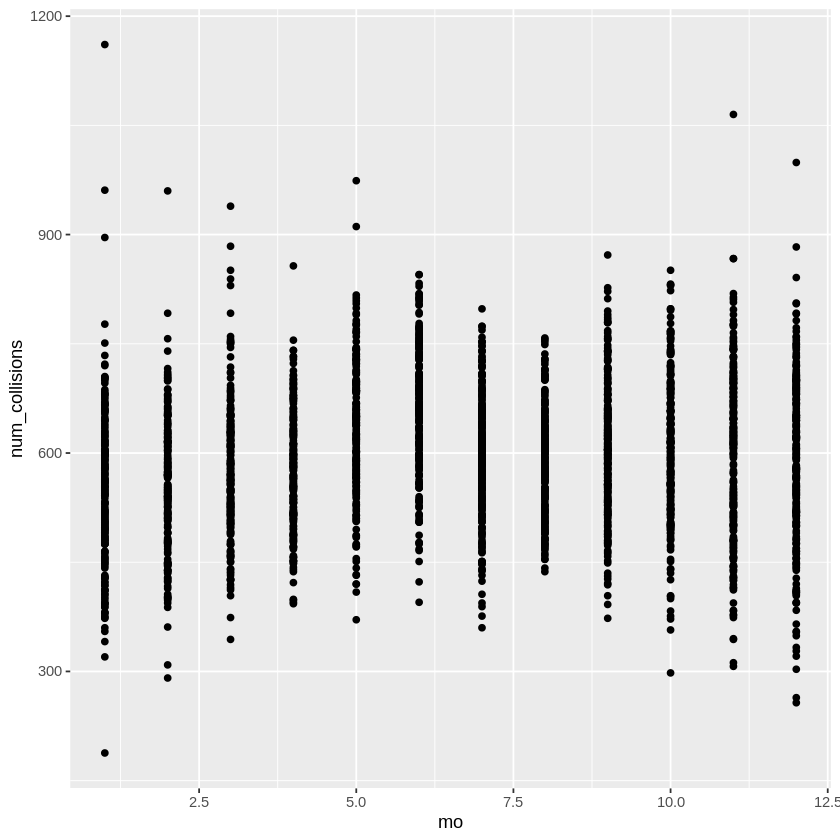

In [161]:
# Month vs Collisions
p_cor_mo_collisions <- collated_clean_rm_20 %>%
  ggplot(aes(x = mo, y = num_collisions)) +
  geom_point()

p_cor_mo_collisions

In [162]:
cor(collated_clean_rm_20$mo, collated_clean_rm_20$num_collisions)

[1] 0.1122182

### Correlation Matrix

We'll create a correlation matrix and then plot this to get an overview of the correlation between each of the variables.

In [163]:
# Select the columns
cor_matrix <- collated_clean_rm_20 %>%
  select(day, mo, temp:num_collisions)

# Create the matrix - used pairwise and the usual complete.obs did not work
cor_matrix <- round(cor(cor_matrix, use = "pairwise.complete.obs"), 2)

cor_matrix

,day,mo,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,num_collisions
day,1.00,0.00,-0.01,-0.01,0.00,0.02,-0.01,0.02,0.01,0.00,-0.01,0.01,NA,0.02,-0.29
mo,0.00,1.00,0.37,0.33,0.07,0.07,-0.20,-0.14,-0.10,0.36,0.35,0.02,NA,-0.06,0.11
temp,-0.01,0.37,1.00,0.96,-0.15,-0.19,-0.36,-0.39,-0.28,0.97,0.96,-0.03,NA,0.22,0.17
dewp,-0.01,0.33,0.96,1.00,-0.19,-0.34,-0.32,-0.35,-0.23,0.92,0.93,0.02,NA,0.33,0.18
slp,0.00,0.07,-0.15,-0.19,1.00,0.31,-0.30,-0.33,-0.33,-0.12,-0.19,-0.29,NA,-0.20,-0.05
visib,0.02,0.07,-0.19,-0.34,0.31,1.00,-0.15,-0.16,-0.21,-0.13,-0.23,-0.24,NA,-0.71,-0.08
wdsp,-0.01,-0.20,-0.36,-0.32,-0.30,-0.15,1.00,0.85,0.76,-0.37,-0.30,0.33,NA,-0.06,0.03
mxpsd,0.02,-0.14,-0.39,-0.35,-0.33,-0.16,0.85,1.00,0.94,-0.40,-0.35,0.37,NA,-0.03,-0.02
gust,0.01,-0.10,-0.28,-0.23,-0.33,-0.21,0.76,0.94,1.00,-0.27,-0.26,0.35,NA,0.05,-0.02
max,0.00,0.36,0.97,0.92,-0.12,-0.13,-0.37,-0.40,-0.27,1.00,0.93,-0.04,NA,0.21,0.17


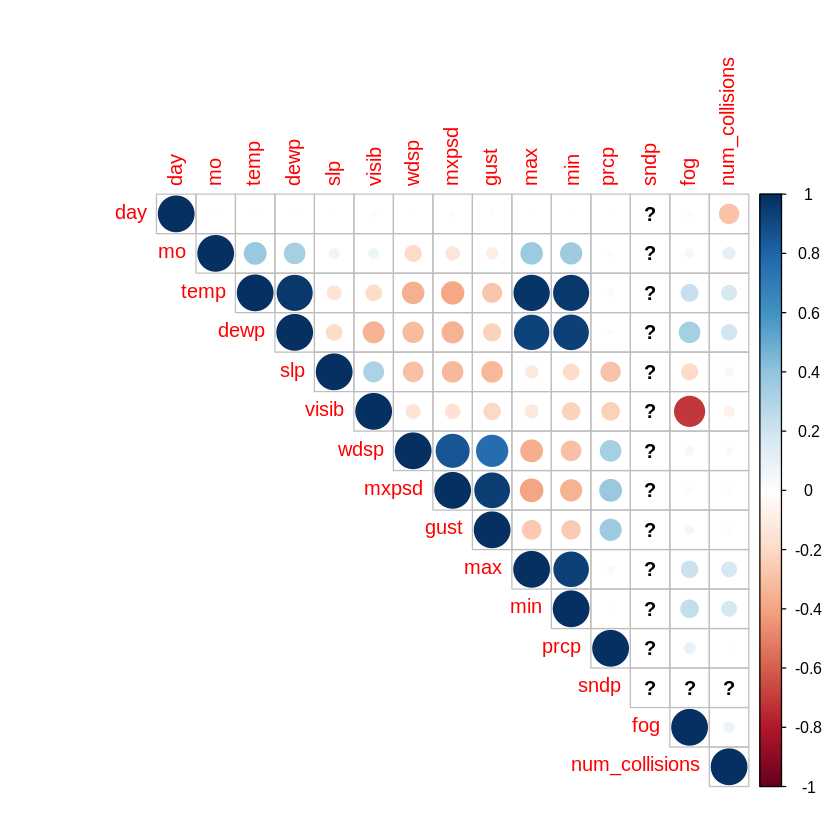

In [164]:
corrplot(cor_matrix, method="circle", type = "upper")

None of the variables have a strong correlation with the number of collisions. However, just based on the correlations alone it looks like the variables we may want to keep are: day of week, month, temperature.

Some of the other variables are correlated and have been excluded due to multicolinearity

* Temp and Dew Point
* Max/Min and Temp/Dew Point
* Visibility and Fog



## Deeper dive on most promising variables

### Day of the Week

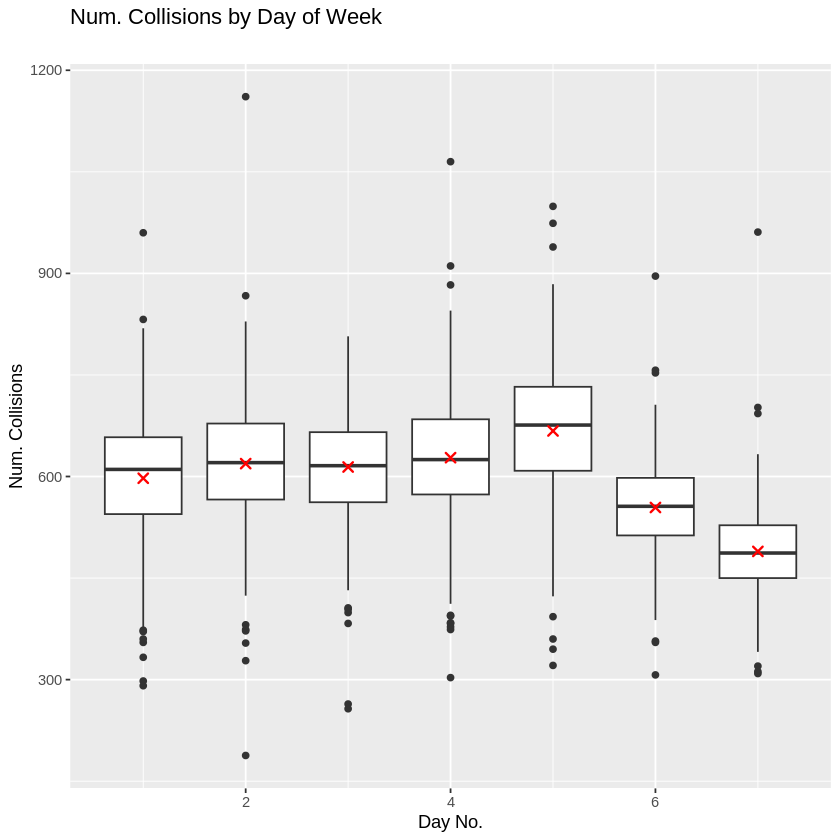

In [165]:
# Collisions by Day of the Week
ggplot(collated_clean_rm_20, aes(x = day, y = num_collisions, group = day)) +
  geom_boxplot() +
  stat_summary(fun = "mean", aes(ymax = after_stat(y), ymin = after_stat(y)), 
               color = "red", shape = 4) +
  scale_y_continuous() +
  labs(title = "Num. Collisions by Day of Week",
       subtitle = "",
       x = "Day No.",
       y = "Num. Collisions") +
  theme(legend.position="none")

Lower number of collisions on the weekend. Less traffic on these days perhaps.

### Month

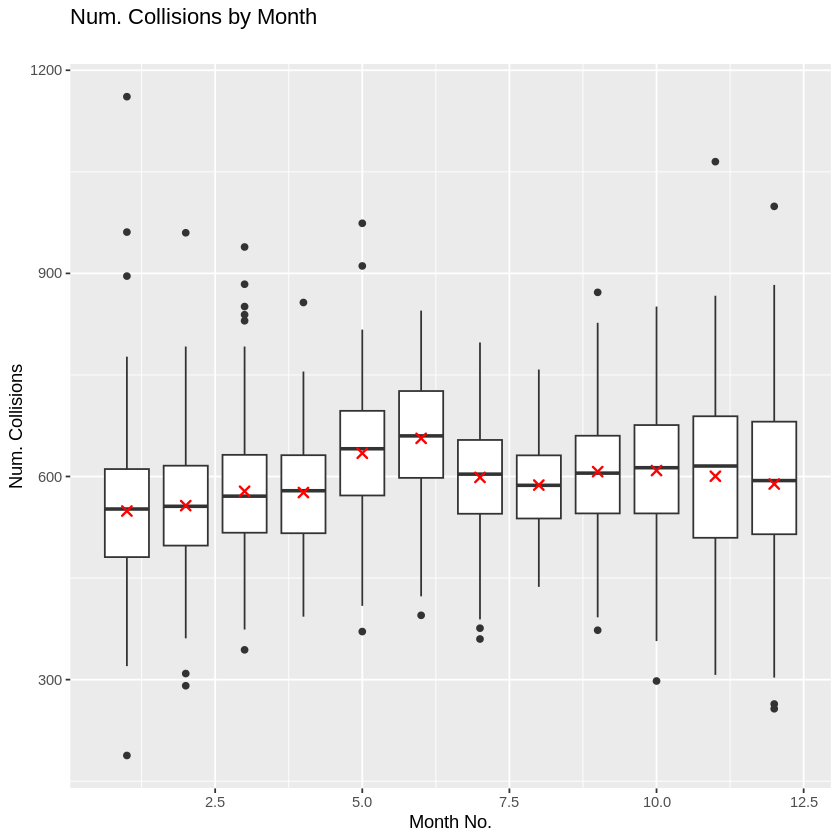

In [166]:
# Collisions by month
ggplot(collated_clean_rm_20, aes(x = mo, y = num_collisions, group = mo)) +
  geom_boxplot() +
  stat_summary(fun = "mean", aes(ymax = after_stat(y), ymin = after_stat(y)), 
               color = "red", shape = 4) +
  scale_y_continuous() +
  labs(title = "Num. Collisions by Month",
       subtitle = "",
       x = "Month No.",
       y = "Num. Collisions") +
  theme(legend.position="none")

As we saw above early summer (May-June) sees a higher volume of collisions per month on average. Could be due to number of cars on the road? Tourism possibly higher during this period?

I would have expected the winter months to see more collisions.

## Standardise Data

In [167]:
# Standardise num. collisions
std_collisions <- collated_clean_rm_20 %>%
  mutate_at(c('num_collisions'), ~scale(.) %>% as.vector())

head(std_collisions)

,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,num_collisions,dayofyear,dayindex
,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
1,7,2012,7,1,2012-07-01,28.7,17.2,1008.9,9.7,4.7,11.4,20.8,33.9,18.9,0.00,NA,0,-0.57495070,183,1
2,1,2012,7,2,2012-07-02,26.8,12.3,1011.6,10.0,4.4,17.3,NA,31.1,19.4,0.00,NA,0,-0.31534210,184,2
3,2,2012,7,3,2012-07-03,26.6,13.7,1012.8,10.0,3.3,13.8,NA,31.1,17.2,0.00,NA,0,0.68315253,185,3
4,3,2012,7,4,2012-07-04,27.7,18.7,1009.1,9.2,4.1,12.8,NA,32.8,20.0,0.06,NA,0,-1.63335501,186,4
5,4,2012,7,5,2012-07-05,30.4,17.9,1007.4,9.4,4.4,17.3,NA,34.4,21.1,NA,NA,0,-0.04574855,187,5
6,5,2012,7,6,2012-07-06,27.7,16.8,1011.7,10.0,3.6,11.4,NA,32.8,19.4,0.00,NA,0,0.42354393,188,6


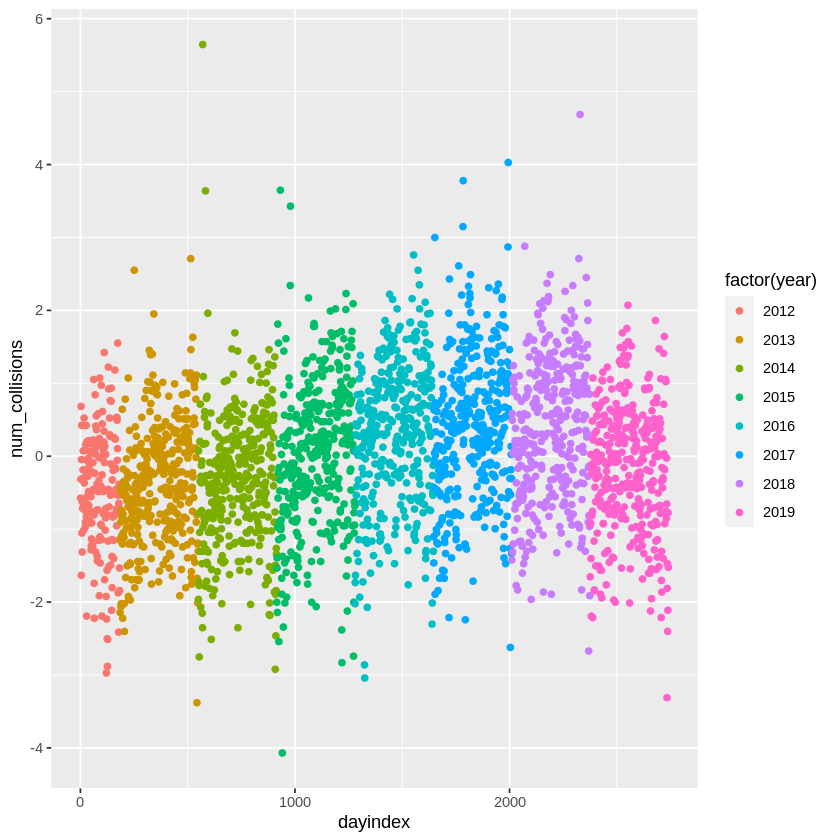

In [168]:
ggplot(std_collisions, aes(x = dayindex, y = num_collisions, colour = factor(year))) +
  geom_point()

## References